In [248]:
### This dataset contains house sale prices for King County, which includes Seattle. 
### It includes homes sold between May 2014 and May 2015.

### It's a great dataset for evaluating simple regression models.

In [249]:
import warnings

warnings.simplefilter('ignore')

In [250]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [251]:
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_squared_error

In [252]:
#importing data

df= pd.read_csv('../input/kc_house_data.csv')

In [253]:
# Exploring the dataset

print(df.shape)

df.head()

(21613, 21)


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [254]:
# we'll create a copy of the DataFrame just to fall back if anything goes wrong

df_copy= df.copy()

In [255]:
print(df.id.nunique())

# we see that the id is almost unique we will drop this feature

df.drop('id', axis=1, inplace= True)

21436


In [256]:
# we will check for any missing values

print(df.isna().sum())
# we see that there are no missing values

date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64


In [257]:
# Let's now convert the date column to look more like a date column

df['Date']= pd.to_datetime(df.date)

In [258]:
print(df.Date.dt.year.nunique()) # we see that there are only two values for year, matches with our description
print(df.Date.dt.month.nunique())
print(df.Date.dt.week.nunique())
print(df.Date.dt.dayofweek.nunique())

# we can conver these as new variables

2
12
52
7


In [259]:
df['Year']= df.Date.dt.year
df['Month']= df.Date.dt.month
df['quarter']= df.Date.dt.quarter
df['weekday']= df.Date.dt.dayofweek


# making date columns

In [260]:
df.sample(7)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,Date,Year,Month,quarter,weekday
16239,20141104T000000,500000.0,4,2.50,3010,5040,2.0,0,0,3,8,3010,0,2006,0,98133,47.7090,-122.350,1090,5040,2014-11-04,2014,11,4,1
8589,20140714T000000,775000.0,4,2.50,2880,8400,2.0,0,4,3,8,2050,830,1955,1987,98177,47.7704,-122.386,2880,7440,2014-07-14,2014,7,3,0
5053,20150225T000000,735000.0,3,1.75,1880,108900,1.0,0,0,3,7,1880,0,1978,0,98075,47.5913,-122.010,2730,37731,2015-02-25,2015,2,1,2
10670,20150217T000000,547000.0,2,1.00,1370,10038,1.5,0,0,4,7,1370,0,1922,0,98133,47.7190,-122.339,1610,8822,2015-02-17,2015,2,1,1
20677,20150403T000000,274950.0,3,2.50,1608,4000,2.0,0,0,3,8,1608,0,2014,0,98092,47.2582,-122.198,2009,4983,2015-04-03,2015,4,2,4
8461,20140811T000000,140000.0,2,1.00,900,6400,1.0,0,0,2,6,900,0,1940,0,98118,47.5287,-122.281,1350,6405,2014-08-11,2014,8,3,0
14705,20150212T000000,315000.0,4,2.00,1210,4250,1.0,0,0,4,7,1210,0,1941,0,98108,47.5275,-122.321,1210,6000,2015-02-12,2015,2,1,3


In [261]:
# let's now check the other features in the dataset
print(f'number of unique values in "lat" are: {df.lat.nunique()}') # there seems to be 5k locations, we will drop this variable for now. 

print(f'number of uniques values in "long" are: {df.long.nunique()}') # we will drop this variable as well for now.

df.drop(['lat', 'long'], axis= 1, inplace= True)

number of unique values in "lat" are: 5034
number of uniques values in "long" are: 752


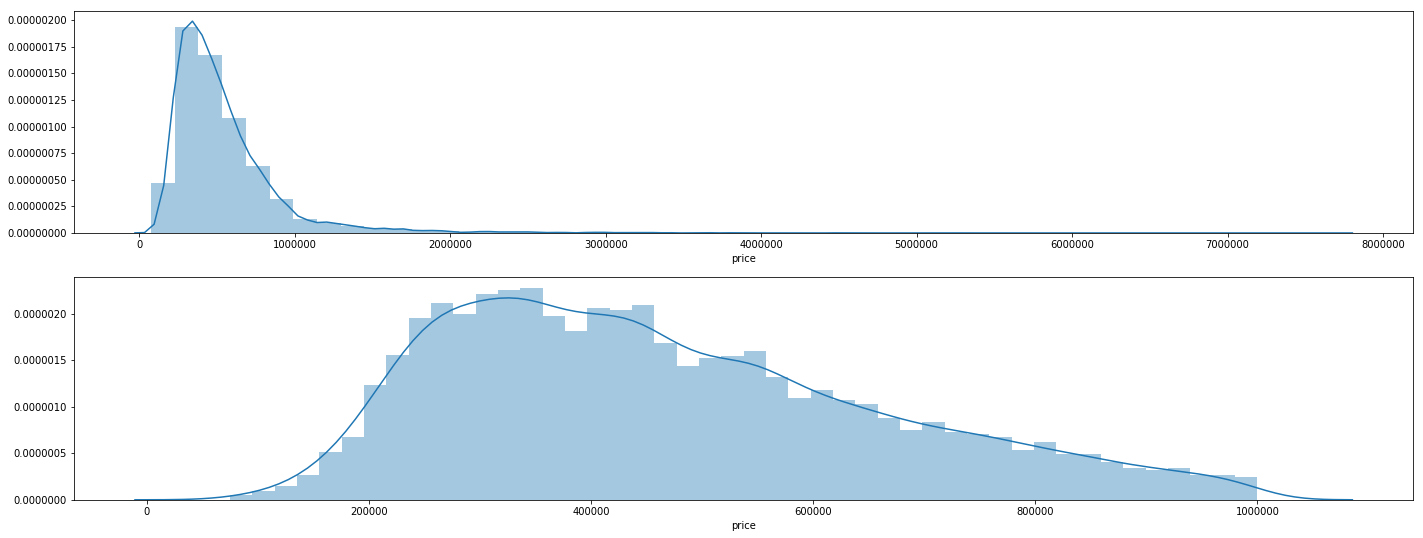

In [262]:
plt.figure(figsize= (24, 9))

plt.subplot(2, 1, 1)

sns.distplot(df.price)

plt.subplot(2, 1, 2)

sns.distplot(df.loc[df.price < 1000000, 'price'], )

# we see that most house prices are below a million and in that below 400 thousand

In [263]:
# we see that there are a number of different sqft listed, we will create a single feature by adding them

sqft_cols = ['sqft_living', 'sqft_above', 'sqft_basement'] 

print(pd.concat([df[sqft_cols].sum(axis= 1), df[sqft_cols]], axis=1).head()) 
# we see that the calculation is now much more realistic

df['Total_sqft']= df[sqft_cols].sum(axis= 1)

#let's check the unique values in the floor feature

print(f'Unique values in floors: {sorted(df.floors.unique())}')
print(f'number of unique values in floors: {df.floors.nunique()}')

# we see that there are 0.5 floors in the variable, let's explore these observations more carefully

      0  sqft_living  sqft_above  sqft_basement
0  2360         1180        1180              0
1  5140         2570        2170            400
2  1540          770         770              0
3  3920         1960        1050            910
4  3360         1680        1680              0
Unique values in floors: [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]
number of unique values in floors: 6


In [264]:
# we will have to convert the datatype to object first

df['floors']= df['floors'].astype('object')

df.loc[(df.floors == 1.5) | (df.floors == 2.5) | (df.floors == 3.5), df.columns[df.columns.str.contains(r'Total|above|basement|living|floors')]].sample(20)

# a little research and I found out that .5 is usally a compromise between between one and two floors,
# we will go without making any changed for now and make this a categorical variable

,sqft_living,floors,sqft_above,sqft_basement,sqft_living15,Total_sqft
3998,1280,1.5,1280,0,1410,2560
12502,2650,1.5,1520,1130,1690,5300
8235,1760,1.5,1760,0,1760,3520
10086,1440,1.5,1440,0,1490,2880
10867,2060,1.5,1580,480,1160,4120
2029,1480,1.5,1480,0,1730,2960
14468,1150,1.5,1150,0,990,2300
18890,3030,1.5,3030,0,2980,6060
17542,2380,1.5,1320,1060,1290,4760
9566,1610,1.5,1060,550,1610,3220


In [265]:
print(df.condition.nunique())
print(df.condition.unique()) # there are 5 unique values, however can't say which is best and worst, 
# but we use the feature anyway

5
[3 5 4 1 2]


In [266]:
print(df.grade.nunique())
print(df.grade.unique()) # we see there are 12 unique variables, similiar to condition

12
[ 7  6  8 11  9  5 10 12  4  3 13  1]


In [267]:
print(df['yr_built'].nunique())
print(df['yr_built'].unique()) #there are 116 unique values, let's plot this to get a better picture

116
[1955 1951 1933 1965 1987 2001 1995 1963 1960 2003 1942 1927 1977 1900
 1979 1994 1916 1921 1969 1947 1968 1985 1941 1915 1909 1948 2005 1929
 1981 1930 1904 1996 2000 1984 2014 1922 1959 1966 1953 1950 2008 1991
 1954 1973 1925 1989 1972 1986 1956 2002 1992 1964 1952 1961 2006 1988
 1962 1939 1946 1967 1975 1980 1910 1983 1978 1905 1971 2010 1945 1924
 1990 1914 1926 2004 1923 2007 1976 1949 1999 1901 1993 1920 1997 1943
 1957 1940 1918 1928 1974 1911 1936 1937 1982 1908 1931 1998 1913 2013
 1907 1958 2012 1912 2011 1917 1932 1944 1902 2009 1903 1970 2015 1934
 1938 1919 1906 1935]


(array([ 3456.,  6383.,  8968., 11754., 14708., 17457., 18745., 19869.,
        20813., 21613.]),
 array([ -1. ,  10.6,  22.2,  33.8,  45.4,  57. ,  68.6,  80.2,  91.8,
        103.4, 115. ]),
 <a list of 10 Patch objects>)

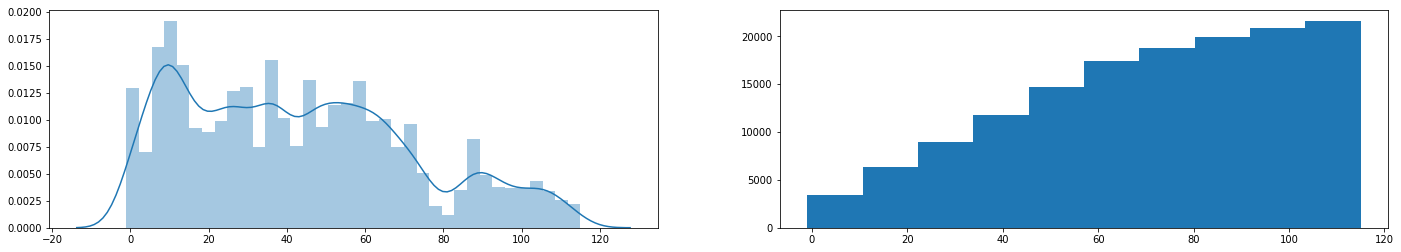

In [268]:
plt.figure(figsize= (24, 4))
plt.subplot(1, 2, 1)
sns.distplot(df['Year'].sub(df['yr_built'])) #this will give the age of the house in the year it was sold

plt.subplot(1, 2, 2)
plt.hist(df['Year'].sub(df['yr_built']), cumulative= True)

# we see that most houses are less than 60 years old. We will create bins for age of houses instead of years

In [269]:
df['Year'].sub(df['yr_built']).min() # there is a negative value, which we will investigate this now.

print(len(df.loc[df['Year'].sub(df['yr_built']) == -1]))

# there are 442 observations with negative value for age of house

df.loc[df['Year'].sub(df['yr_built']) == -1].sample(10)

## the observations show that the year built is a year later than the year sold, this could mean that 
## the house could have been while still under construction bought in the constrcution phase,
## but we will change these values to 1 for now.

12


,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Date,Year,Month,quarter,weekday,Total_sqft
20852,20140709T000000,595000.0,4,3.25,3730,4560,2,0,0,3,9,2760,970,2015,0,98103,1800,4560,2014-07-09,2014,7,3,2,7460
2687,20141029T000000,385195.0,1,1.00,710,6000,1.5,0,0,3,6,710,0,2015,0,98144,1440,4800,2014-10-29,2014,10,4,2,1420
8039,20140624T000000,455000.0,2,1.50,1200,1259,2,0,0,3,8,1000,200,2015,0,98144,1320,1852,2014-06-24,2014,6,2,1,2400
20963,20140731T000000,230000.0,3,1.50,1040,1264,2,0,0,3,9,900,140,2015,0,98144,1350,3000,2014-07-31,2014,7,3,3,2080
21262,20141125T000000,559000.0,2,3.00,1650,960,3,0,0,3,8,1350,300,2015,0,98103,1650,3000,2014-11-25,2014,11,4,1,3300
7526,20141231T000000,614285.0,5,2.75,2730,6401,2,0,0,3,8,2730,0,2015,0,98072,2520,6126,2014-12-31,2014,12,4,2,5460
1763,20140625T000000,597326.0,4,4.00,3570,8250,2,0,0,3,10,2860,710,2015,0,98040,2230,10000,2014-06-25,2014,6,2,2,7140
14489,20140826T000000,500000.0,2,2.25,1570,1269,2,0,0,3,9,1280,290,2015,0,98199,1570,6000,2014-08-26,2014,8,3,1,3140
17098,20140617T000000,350000.0,3,2.00,1380,3600,3,0,0,3,8,1380,0,2015,0,98122,1480,3600,2014-06-17,2014,6,2,1,2760
21372,20140520T000000,490000.0,5,3.50,4460,2975,3,0,2,3,10,3280,1180,2015,0,98119,2490,4231,2014-05-20,2014,5,2,1,8920


In [270]:
df['age_of_house']= df['Year'].sub(df['yr_built']) 
# here we are creating a new variable to calculate the age of the house and then create bins for them later

print(df['age_of_house'].nunique())
print(df['age_of_house'].unique())

# let's proceed to create bins. we'll check the minimum and maximum values for our reference

print(f'Lowest value in age variable is: {df["age_of_house"].min()}')
print(f'Highest value in age variable is: {df["age_of_house"].max()}')
# highest value in the field is 115, and lowest is -1, this means that the house was pre-booked

117
[ 59  63  82  49  28  13  19  52  55  12  50  72  87  37 115  36  20  98
  93  46  67  29  73  99 105  66  10  11   9  85  33  84  81 110  18  14
  30   0  92  62  64  34  88   6  24  60  41  35  89  25  43  58  74  22
  51  53   8  26  75  68  48  39 104  31 114   4  69  65  90  27 101  47
  54 109   7  61  15  38  16 113  21  94  45 100 111  96  97  86 103  78
  77  76 107  40  57 102  17  71   1  23  91  42  95   2  32   3  56  70
  44 112   5  80  83 106 108  79  -1]
Lowest value in age variable is: -1
Highest value in age variable is: 115


In [271]:
age_cond = [
    ((df['age_of_house']>= 0) & (df['age_of_house']<= 20)),
    ((df['age_of_house']> 20) & (df['age_of_house']<= 40)),
    ((df['age_of_house']> 40) & (df['age_of_house']<= 60)),
    ((df['age_of_house']> 60) & (df['age_of_house']<= 80)),
    ((df['age_of_house']> 80) & (df['age_of_house']<= 100)),
    (df['age_of_house']> 100),
    (df['age_of_house']< 0)
]

age_choices = ['0-20', '21-40', '41-60', '61-80', '81-100', '100+', 'Pre-booked']


age_bins= np.select(age_cond, choicelist=age_choices, default='Missed')
# let's now check the variable to see if everything went right

In [272]:
# pd.concat([pd.Series(age_bins), df['age_of_house']], axis= 1).sample(20)
# # we see that all the sample bins were created correctly.

# #we'll procees and add this to the DataFrame

df['age_bins']= age_bins

df['age_bins'].value_counts(dropna= False)
# Perfecto!
# we see that there are only 12 pre-booked houses.

0-20          5962
21-40         5006
41-60         4674
61-80         3091
81-100        1856
100+          1012
Pre-booked      12
Name: age_bins, dtype: int64

In [273]:
df.head()

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Date,Year,Month,quarter,weekday,Total_sqft,age_of_house,age_bins
0,20141013T000000,221900.0,3,1.00,1180,5650,1,0,0,3,7,1180,0,1955,0,98178,1340,5650,2014-10-13,2014,10,4,0,2360,59,41-60
1,20141209T000000,538000.0,3,2.25,2570,7242,2,0,0,3,7,2170,400,1951,1991,98125,1690,7639,2014-12-09,2014,12,4,1,5140,63,61-80
2,20150225T000000,180000.0,2,1.00,770,10000,1,0,0,3,6,770,0,1933,0,98028,2720,8062,2015-02-25,2015,2,1,2,1540,82,81-100
3,20141209T000000,604000.0,4,3.00,1960,5000,1,0,0,5,7,1050,910,1965,0,98136,1360,5000,2014-12-09,2014,12,4,1,3920,49,41-60
4,20150218T000000,510000.0,3,2.00,1680,8080,1,0,0,3,8,1680,0,1987,0,98074,1800,7503,2015-02-18,2015,2,1,2,3360,28,21-40


In [274]:
# let's check the yr_renovated feature now.

print(df['yr_renovated'].nunique())
# we see that there are 70 values, let's create a variable for renovation age also a binary column 
# indicating if any renovation was done to the house.

modification_age = np.where(df['yr_renovated']== 0, 0, df['Year'].sub(df['yr_built']))

modification_age[:50]
# We see that there are very less modifications done, so we need not create a separate binary column to 
# idicate this, we can create one column with the age which can again be a bin and 0s can be converted to 
# string sying 'not renovated'

70


array([ 0, 63,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0, 84,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0])

In [275]:
reno_cond = [
    ((modification_age>0) & (modification_age<= 20)),
    ((modification_age>20) & (modification_age<= 40)),
    ((modification_age>40) & (modification_age<= 60)),
    ((modification_age>60) & (modification_age<= 80)),
    ((modification_age>80) & (modification_age<= 100)),
    (modification_age> 100), (modification_age == 0)
] # we can copy paste this condition from age choice and make necessary changes to it

reno_choices = ['0-20', '21-40', '41-60', '61-80', '81-100', '100+', 'Not Renovated']

reno_variable= np.select(reno_cond, reno_choices, default='Missed')

print(reno_variable[:50])

print(modification_age[:50])

# we see that the conditions were applied correctly.

['Not Renovated' '61-80' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' '81-100' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated'
 'Not Renovated' 'Not Renovated' 'Not Renovated' 'Not Renovated']
[ 0 63  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0 84  0  0  0  0  0  0  0  0  0  0  0  0
  0  0]


In [276]:
df['renovations']= reno_variable

print(df['renovations'].value_counts(dropna= False))
# perfecto!
# Here however we see that not many houses have been renovated, so we have limited data, we can club these 
# ages to just say renovated making the column a binary variable.
df['renovations']= np.where(df['renovations']== 'Not Renovated', 'Not Renovated', 'Renovated')

print(df['renovations'].value_counts(dropna= False)) # we just have 914 values for renovated this might 
# not make any difference in the model, we'll check this later

Not Renovated    20699
61-80              291
81-100             215
41-60              184
100+               161
21-40               58
0-20                 5
Name: renovations, dtype: int64
Not Renovated    20699
Renovated          914
Name: renovations, dtype: int64


In [277]:
# let's check zipcode

df['zipcode'].nunique() # We have 70 values for zipcodes, we will drop them later or check if we can use 
# them somehow.

70

In [278]:
print(pd.concat([df[df.columns[df.columns.str.contains('living')]], df['renovations']], axis= 1).sample(10))

# we see that sqft_living in 2015 has changed(decreased or increased) in some observations but not 
# marked as renovated. We do not know why this is, so we will create a categorical variable that says 
# "decreased", "increased" or "unchanged"

sqft_living_conds= [
    (df['sqft_living15'].sub(df['sqft_living']) < 0),
    (df['sqft_living15'].sub(df['sqft_living']) > 0),
    (df['sqft_living15'].sub(df['sqft_living']) == 0)
]

sqft_living_choices= ['Decreased', 'Increased', 'Unchanged']

sqft_change= np.select(sqft_living_conds, sqft_living_choices, 'Missed')

print(pd.concat([pd.Series(sqft_change), df[df.columns[df.columns.str.contains('living')]]], axis= 1).head(7))
# we see that the conds were applied correctly.

       sqft_living  sqft_living15    renovations
11653         1660           1660  Not Renovated
18221         1770           1770  Not Renovated
18606         2860           1840      Renovated
9022          2810           2810  Not Renovated
19006         1090           1640  Not Renovated
16682         1550           1450  Not Renovated
17119         1330           1900  Not Renovated
6754          3410           2550  Not Renovated
16838         1130           1190  Not Renovated
21181         2870           2940  Not Renovated
           0  sqft_living  sqft_living15
0  Increased         1180           1340
1  Decreased         2570           1690
2  Increased          770           2720
3  Decreased         1960           1360
4  Increased         1680           1800
5  Decreased         5420           4760
6  Increased         1715           2238


In [279]:
df['sqft_liv_change']= sqft_change
# adding to the DataFrame

df['sqft_liv_change'].value_counts(dropna= False)

Decreased    9841
Increased    9206
Unchanged    2566
Name: sqft_liv_change, dtype: int64

In [280]:
# we'll check the min and max values in sqft_basement, sqft_living and sqft_above features

for i in ['sqft_living', 'sqft_above', 'sqft_basement']:
    
    print(f'Min value in {i} is: {df[i].min()}')
    print(f'Max value in {i} is: {df[i].max()}')
    
    ## we see that there are 0 values in basement, which we saw earlier and used to create a new variable
    
    ## we can create new variables from sqft_living and sqft_above features which we will see now         

Min value in sqft_living is: 290
Max value in sqft_living is: 13540
Min value in sqft_above is: 290
Max value in sqft_above is: 9410
Min value in sqft_basement is: 0
Max value in sqft_basement is: 4820


In [281]:
df.loc[df['sqft_basement'] > 0, 'sqft_basement'].describe([.25, .5, .75, .95])

# we see that min value in the basement feature is 10, we will not delve deeper into that but 
# let's create categories for now

count    8487.000000
mean      742.357134
std       405.111631
min        10.000000
25%       450.000000
50%       700.000000
75%       980.000000
95%      1450.000000
max      4820.000000
Name: sqft_basement, dtype: float64

In [282]:
# let's check percentiles in sqft columns
for i in ['sqft_living', 'sqft_above', 'sqft_basement']:
    
    print(f'25th, 50th, 75th and 95th percentiles in {i} are: {np.percentile(df[i], [25,50,75,95])}')

25th, 50th, 75th and 95th percentiles in sqft_living are: [1427. 1910. 2550. 3760.]
25th, 50th, 75th and 95th percentiles in sqft_above are: [1190. 1560. 2210. 3400.]
25th, 50th, 75th and 95th percentiles in sqft_basement are: [   0.    0.  560. 1190.]


In [283]:
#sqft_basement
basement_conds= [
    ((df['sqft_basement'] > 0) & (df['sqft_basement'] <= 450)),
    ((df['sqft_basement'] > 450) & (df['sqft_basement'] <= 700)),
    ((df['sqft_basement'] > 700) & (df['sqft_basement'] <= 980)),
    ((df['sqft_basement'] > 980) & (df['sqft_basement'] <= 1450)),
    (df['sqft_basement'] > 1450),
    (df['sqft_basement'] == 0)
]

basement_choice= ['Small', 'Moderate', 'Large', 'Huge', 'Humungous','No Basement']

df['basement_size']= np.select(basement_conds, basement_choice, 'Missed')


#sqft_living
living_conds= [
    ((df['sqft_living'] > 0) & (df['sqft_living'] <= 1427)),
    ((df['sqft_living'] > 1427) & (df['sqft_living'] <= 1910)),
    ((df['sqft_living'] > 1910) & (df['sqft_living'] <= 2550)),
    ((df['sqft_living'] > 2550) & (df['sqft_living'] <= 3760)),
    (df['sqft_living'] > 3760),
    (df['sqft_living'] == 0)
]

basement_choice= ['Small', 'Moderate', 'Large', 'Huge', 'Humungous','No living area']

df['living_size']= np.select(living_conds, basement_choice, 'Missed')

#sqft_above

above_conds= [
    ((df['sqft_above'] > 0) & (df['sqft_above'] <= 1190)),
    ((df['sqft_above'] > 1190) & (df['sqft_above'] <= 1560)),
    ((df['sqft_above'] > 1560) & (df['sqft_above'] <= 2210)),
    ((df['sqft_above'] > 2210) & (df['sqft_above'] <= 3400)),
    (df['sqft_above'] > 3400),
    (df['sqft_above'] == 0)
]

basement_choice= ['Small', 'Moderate', 'Large', 'Huge', 'Humungous','Nothing Above']

df['above_size']= np.select(above_conds, basement_choice, 'Missed')

In [284]:
df.sample(7)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Date,Year,Month,quarter,weekday,Total_sqft,age_of_house,age_bins,renovations,sqft_liv_change,basement_size,living_size,above_size
12383,20141103T000000,164000.0,3,1.00,1070,8250,1,0,0,3,7,1070,0,1961,0,98092,1190,8250,2014-11-03,2014,11,4,0,2140,53,41-60,Not Renovated,Increased,No Basement,Small,Small
3054,20141028T000000,308000.0,2,1.00,1080,6250,1,0,2,4,7,1080,0,1942,1968,98118,2100,6875,2014-10-28,2014,10,4,1,2160,72,61-80,Renovated,Increased,No Basement,Small,Small
20234,20150421T000000,790000.0,4,2.50,2650,5000,2,0,0,3,8,2650,0,2007,0,98116,1110,6250,2015-04-21,2015,4,2,1,5300,8,0-20,Not Renovated,Decreased,No Basement,Huge,Huge
5768,20150303T000000,638250.0,4,2.50,2460,8029,2,0,0,3,9,2460,0,1989,0,98074,2420,7987,2015-03-03,2015,3,1,1,4920,26,21-40,Not Renovated,Decreased,No Basement,Large,Huge
16153,20140616T000000,245000.0,2,1.00,1200,4880,1,0,0,3,6,980,220,1943,0,98106,1040,4880,2014-06-16,2014,6,2,0,2400,71,61-80,Not Renovated,Decreased,Small,Small,Small
12361,20140813T000000,367950.0,3,1.75,2290,8234,1,0,0,4,7,1250,1040,1950,0,98133,1660,7200,2014-08-13,2014,8,3,2,4580,64,61-80,Not Renovated,Decreased,Huge,Large,Moderate
19991,20140930T000000,295000.0,3,1.50,1220,3286,2,0,0,3,7,1220,0,1982,0,98033,1220,2640,2014-09-30,2014,9,3,1,2440,32,21-40,Not Renovated,Unchanged,No Basement,Small,Moderate


In [285]:
for i in ['living_size', 'above_size', 'basement_size']:
    
    print(f'Values in {i} are \n {df[i].value_counts(dropna= False)}')
    print("")
    
    # we see there are no unwanted results in the dataFrame

Values in living_size are 
 Large        5434
Moderate     5416
Small        5404
Huge         4279
Humungous    1080
Name: living_size, dtype: int64

Values in above_size are 
 Moderate     5435
Small        5415
Large        5373
Huge         4330
Humungous    1060
Name: above_size, dtype: int64

Values in basement_size are 
 No Basement    13126
Small           2205
Moderate        2124
Large           2089
Huge            1646
Humungous        423
Name: basement_size, dtype: int64



In [286]:
lot_change= pd.Series(np.where(df['sqft_lot15']==0, 0,df['sqft_lot15'].sub(df['sqft_lot'])))

In [287]:
lot_change[:20]

df['sqft_lot_change']= pd.Series(np.where(lot_change < 0, 'Decreased', np.where(lot_change > 0, 'Increased', 'Unchanged')))

df['sqft_lot_change'].value_counts(dropna= False)
# looks like the code worked just fine.

Decreased    8598
Increased    8540
Unchanged    4475
Name: sqft_lot_change, dtype: int64

In [288]:
df.sample(5)

,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,sqft_living15,sqft_lot15,Date,Year,Month,quarter,weekday,Total_sqft,age_of_house,age_bins,renovations,sqft_liv_change,basement_size,living_size,above_size,sqft_lot_change
16841,20140519T000000,446000.0,5,2.75,2190,12687,1,0,0,5,7,1370,820,1978,0,98028,2280,10784,2014-05-19,2014,5,2,0,4380,36,21-40,Not Renovated,Increased,Large,Large,Moderate,Decreased
15446,20141013T000000,290000.0,4,2.50,1850,5674,2,0,0,3,7,1850,0,1993,0,98042,1750,6875,2014-10-13,2014,10,4,0,3700,21,21-40,Not Renovated,Decreased,No Basement,Moderate,Large,Increased
5664,20150428T000000,800000.0,3,2.50,2100,4440,2,0,4,3,7,2100,0,1945,0,98116,2100,6000,2015-04-28,2015,4,2,1,4200,70,61-80,Not Renovated,Unchanged,No Basement,Large,Large,Increased
11330,20141014T000000,619500.0,4,2.50,2210,5077,1.5,0,0,4,8,1480,730,1912,0,98126,1740,5000,2014-10-14,2014,10,4,1,4420,102,100+,Not Renovated,Decreased,Large,Large,Moderate,Decreased
10318,20141217T000000,800000.0,4,2.75,4600,322188,1,0,4,3,10,2400,2200,1989,0,98045,3740,114562,2014-12-17,2014,12,4,2,9200,25,21-40,Not Renovated,Decreased,Humungous,Humungous,Huge,Decreased


In [289]:
# we'll now check the size of the houses.

df['Total_sqft'].describe([.25, .5, .75, .95])

count    21613.000000
mean      4159.799473
std       1836.881794
min        580.000000
25%       2854.000000
50%       3820.000000
75%       5100.000000
95%       7520.000000
max      27080.000000
Name: Total_sqft, dtype: float64

In [290]:
house_conds= [
    (df['Total_sqft'] <= 2854),
    ((df['Total_sqft'] > 2854) & (df['Total_sqft'] <= 3820)),
    ((df['Total_sqft'] > 3820) & (df['Total_sqft'] <= 5100)),   
    ((df['Total_sqft'] > 5100) & (df['Total_sqft'] <= 7520)),
    (df['Total_sqft'] > 7520),
]

house_choice= ['Small', 'Moderate', 'Large', 'Huge', 'Humungous']

df['house_size']= np.select(house_conds, house_choice, 'Missed')

df['house_size'].value_counts(dropna= False)

Large        5434
Moderate     5416
Small        5404
Huge         4279
Humungous    1080
Name: house_size, dtype: int64

In [291]:
df['zipcode'].unique()

array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

In [292]:
zips_location= {'98178': 'Seattle', '98125': 'Seattle', '98028': 'Kenmore', '98136': 'Seattle', '98074': 'Sammamish'
 ,'98053': 'Redmond', '98003': 'Federal', '98198': 'Seattle', '98146': 'Seattle', '98038': 'Maple Valley'
 ,'98007': 'Bellevue', '98115': 'Seattle', '98107': 'Seattle', '98126': 'Seattle', '98019': 'Duvall'
 ,'98103': 'Seattle', '98002': 'Auburn', '98133': 'Seattle', '98040': 'Mercer Island','98092': 'Auburn'
 ,'98030': 'Kent', '98119': 'Seattle', '98112': 'Seattle', '98052': 'Redmond', '98027': 'Issaquah', '98117': 'Seattle',
'98058': 'Renton', '98001': 'Auburn', '98056': 'Renton', '98166': 'Seattle', '98023': 'Federal'
 ,'98070': 'Vashon', '98148': 'Seattle', '98105': 'Seattle', '98042': 'Kent', '98008': 'Bellevue', '98059': 'Renton'
 ,'98122': 'Seattle', '98144': 'Seattle', '98004': 'Bellevue', '98005': 'Bellevue', '98034': 'Kirkland' 
 ,'98075': 'Sammamish', '98116': 'Seattle', '98010': 'Black Diamond', '98118': 'Seattle', '98199': 'Seattle'
 ,'98032': 'Kent', '98045': 'North Bend', '98102': 'Seattle', '98077': 'Woodinville', '98108': 'Seattle'
 ,'98168': 'Seattle', '98177': 'Seattle', '98065': 'Snoqualmie', '98029': 'Issaquah', '98006': 'Bellevue'
 ,'98109': 'Seattle', '98022': 'Enumclaw', '98033': 'Kirkland', '98155': 'Seattle', '98024':'Fall City'
 ,'98011': 'Bothell', '98031':'Kent', '98106': 'Kent', '98072': 'Woodinville', '98188': 'Seattle'
 ,'98014': 'Carnation', '98055': 'Renton', '98039':'Medina'}

# this was done using a zipcode search!

In [293]:
df['zipcode']= df['zipcode'].apply(str)

In [294]:
df['zipcode']= df['zipcode'].replace(zips_location)

In [295]:
print(df['zipcode'].nunique())
print(df['zipcode'].value_counts())

24
Seattle          8642
Renton           1597
Kent             1538
Bellevue         1407
Redmond           979
Kirkland          977
Auburn            912
Sammamish         800
Federal           779
Issaquah          733
Maple Valley      590
Woodinville       471
Snoqualmie        310
Kenmore           283
Mercer Island     282
Enumclaw          234
North Bend        221
Bothell           195
Duvall            190
Carnation         124
Vashon            118
Black Diamond     100
Fall City          81
Medina             50
Name: zipcode, dtype: int64


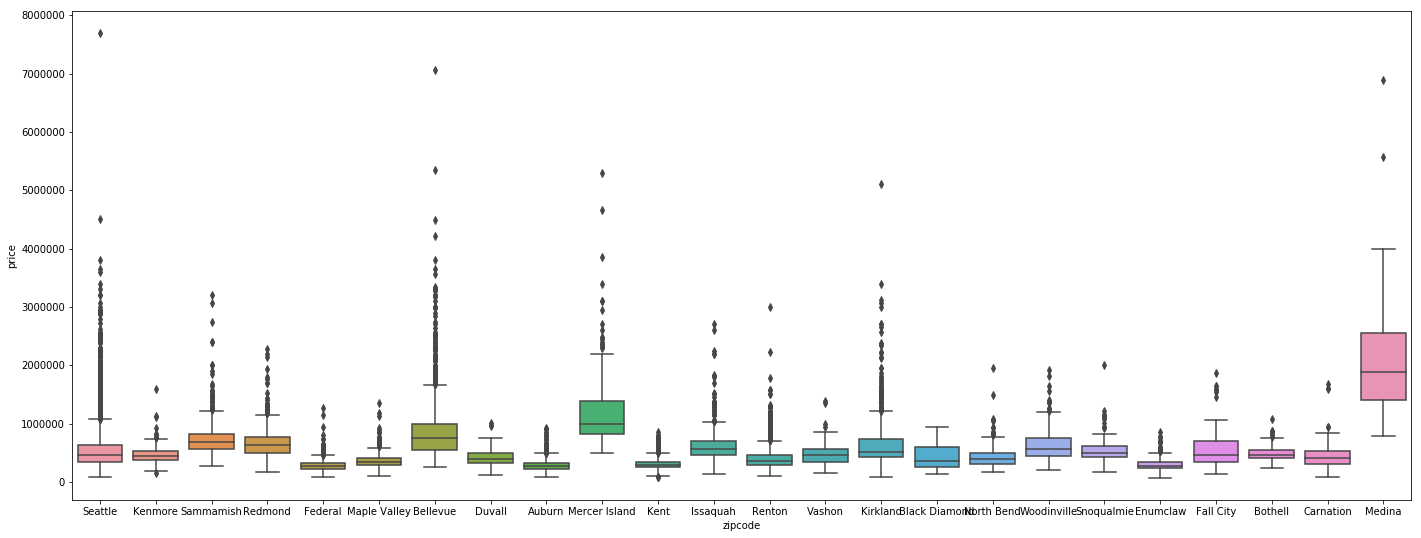

In [296]:
plt.figure(figsize= (24, 9))
sns.boxplot(x='zipcode', y='price', data= df)

# we see that locations do have a influence over the target variable, so we will keep the variable in the df

In [297]:
# Now that we have taken care of lot the features we will explore the relations between the predictors 
# and the target variable

# we will drop a few features before EDA

df.drop(['date', 'yr_built', 'yr_renovated', 'Date', 'age_of_house'], axis= 1, inplace= True)

In [298]:
df.sample(5)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,Year,Month,quarter,weekday,Total_sqft,age_bins,renovations,sqft_liv_change,basement_size,living_size,above_size,sqft_lot_change,house_size
13902,539500.0,4,3.50,2710,5722,2,0,0,4,8,2040,670,Seattle,2500,5722,2014,12,4,1,5420,0-20,Not Renovated,Decreased,Moderate,Huge,Large,Unchanged,Huge
10361,375000.0,4,2.25,2100,12738,2,0,0,4,8,2100,0,Renton,2000,12090,2014,8,3,2,4200,21-40,Not Renovated,Decreased,No Basement,Large,Large,Decreased,Large
2246,509950.0,3,2.50,1970,9153,2,0,0,3,8,1970,0,Kenmore,1800,9800,2014,9,3,1,3940,0-20,Not Renovated,Decreased,No Basement,Large,Large,Increased,Large
14137,295000.0,4,1.00,980,3000,1.5,0,0,4,7,980,0,Seattle,1525,3000,2015,4,2,0,1960,100+,Not Renovated,Increased,No Basement,Small,Small,Unchanged,Small
11678,359000.0,4,1.00,2180,10617,1.5,0,0,3,7,2180,0,Seattle,1360,9519,2014,12,4,2,4360,61-80,Not Renovated,Decreased,No Basement,Large,Large,Decreased,Large


In [299]:
objs_cols= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view', 'condition', 'grade', 'Year', 'Month', 'dayofweek'
, 'age_bins', 'renovations', 'sqft_liv_change', 'basement_size', 'living_size', 'above_size'
, 'sqft_lot_change', 'house_size', 'quarter', 'zipcode']

num_cols= ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_living15', 'sqft_lot15'
           , 'Total_sqft', ]

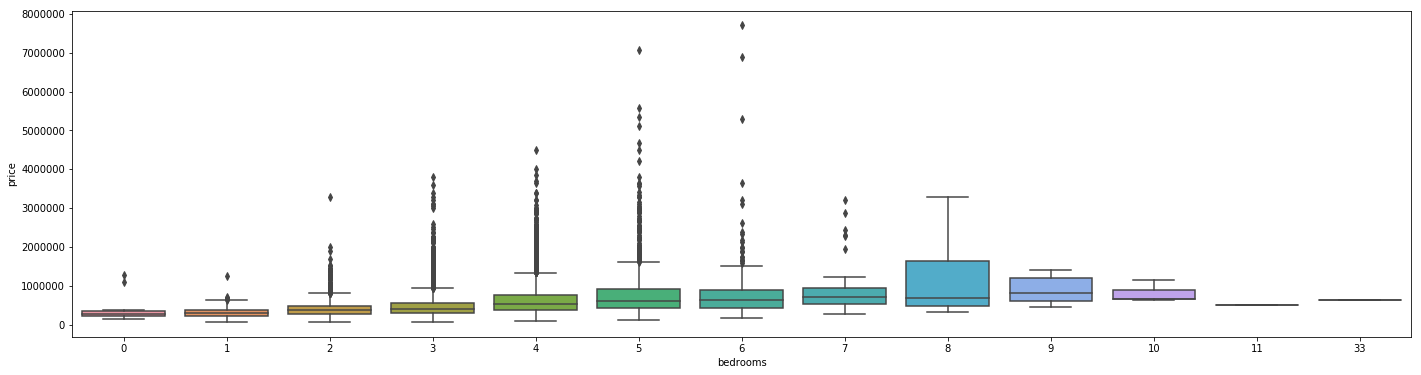

In [300]:
plt.figure(figsize= (24, 6))
sns.boxplot(x= 'bedrooms', y= 'price', data= df)

# we see that there are significant difference in price with higher number of bedrooms, except for 
# houses with greater than 8 rooms, this could also be due to locations

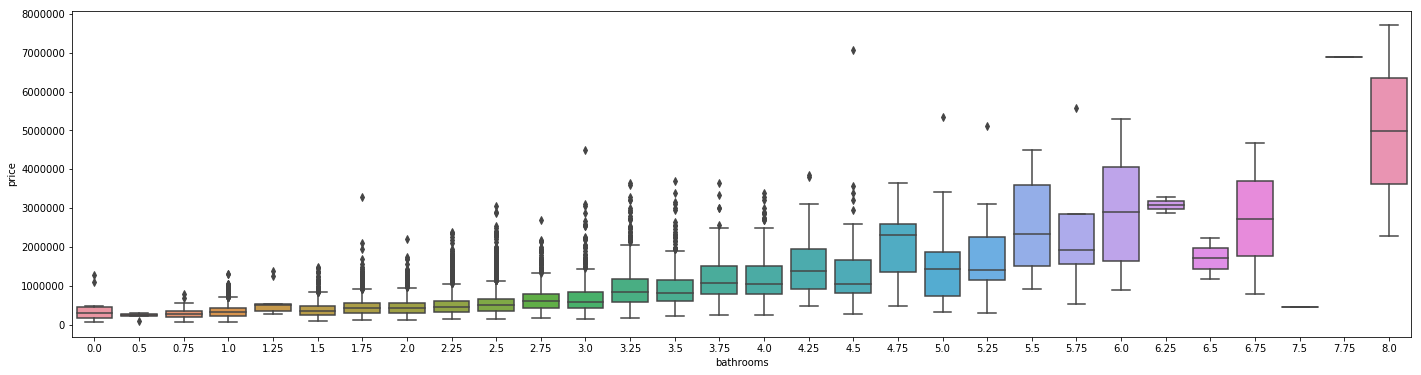

In [301]:
plt.figure(figsize= (24, 6))
sns.boxplot(x= 'bathrooms', y= 'price', data= df)
# see there are differences in house prices with higher number of bathrooms

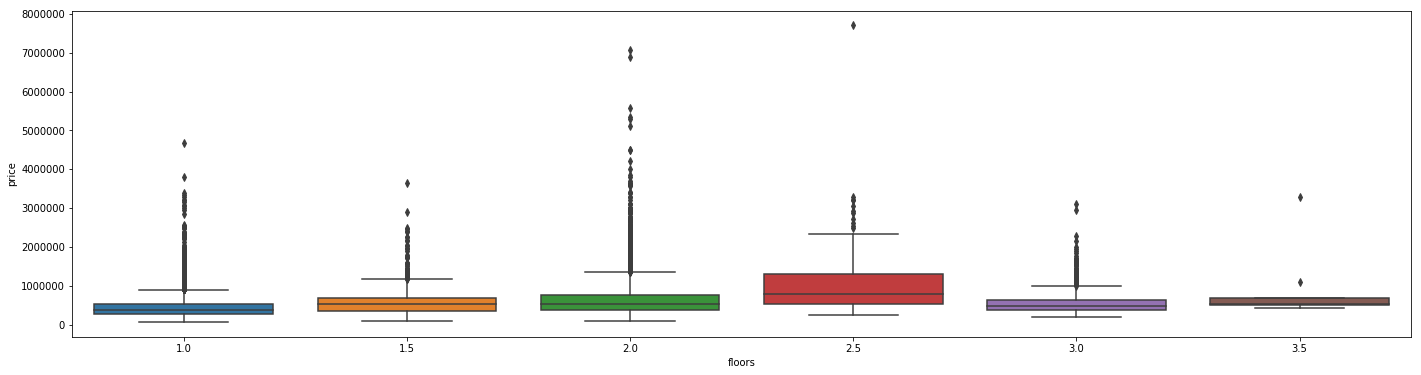

In [302]:
plt.figure(figsize= (24, 6))
sns.boxplot(x= 'floors', y= 'price', data= df)
# see there are differences in house prices with higher number of bathrooms

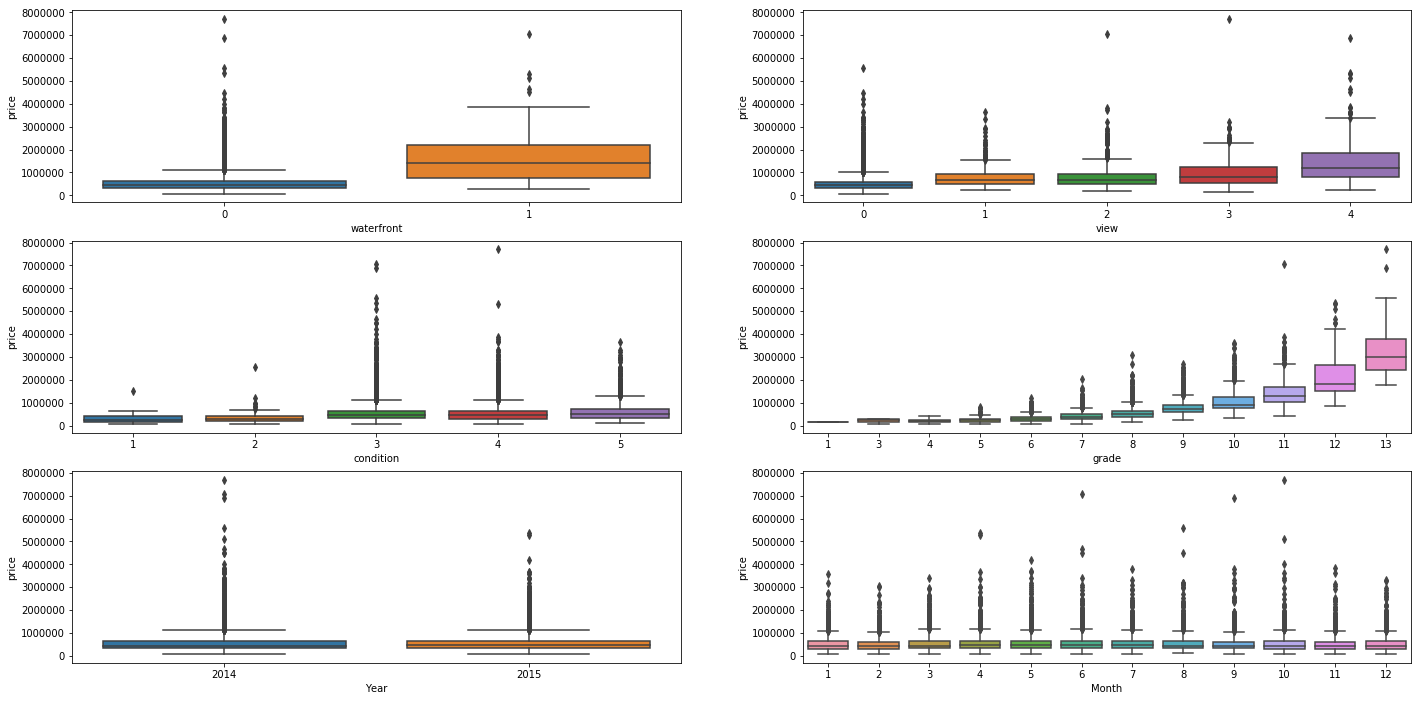

In [303]:
plt.figure(figsize= (24, 12))

for idx, col in enumerate(['waterfront', 'view', 'condition', 'grade', 'Year', 'Month']):
    
    plt.subplot(3, 2, idx+ 1)
    
    sns.boxplot(x= col, y= 'price', data= df)

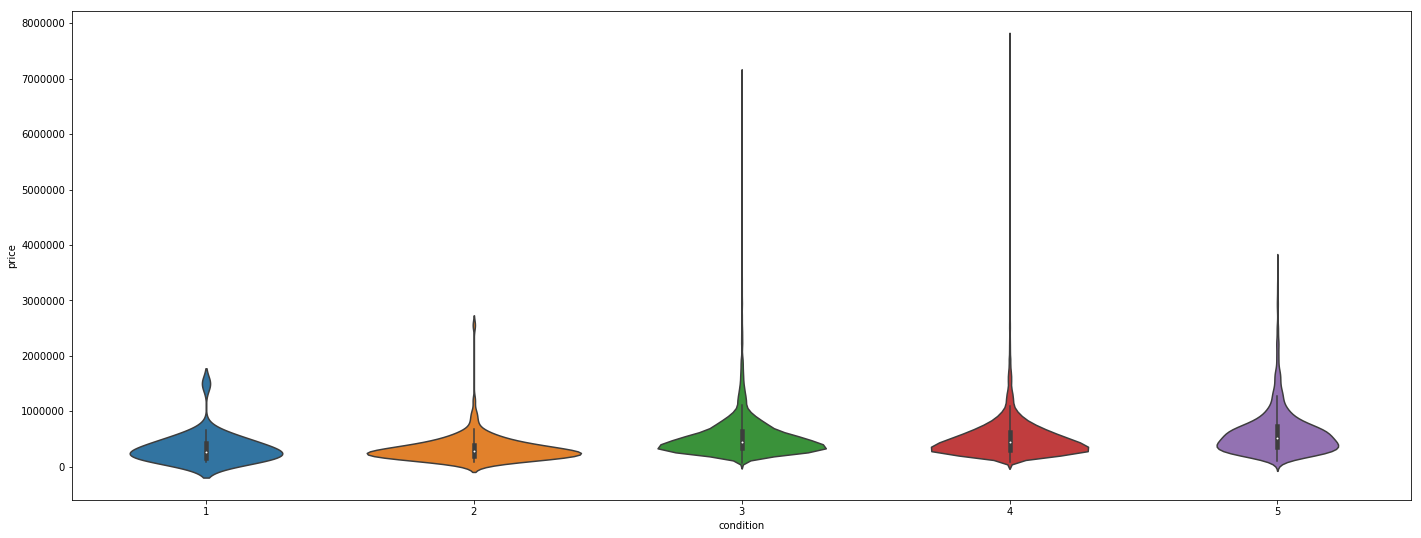

In [304]:
# we'll check the condition and months features a little more closely

plt.figure(figsize= (24, 9))
sns.violinplot(x= 'condition', y= 'price', data= df)

# condition does not seem to be such a good feature, but we will keep it and check feature importance

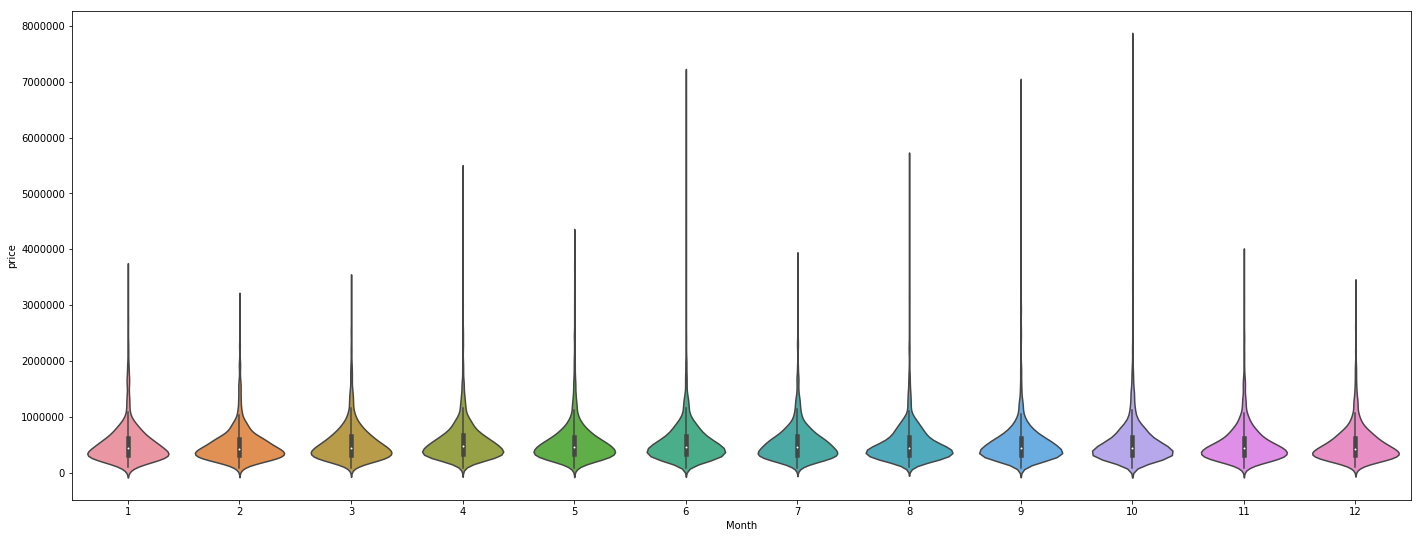

In [305]:
# we'll check the condition and months features a little more closely

plt.figure(figsize= (24, 9))
sns.violinplot(y= 'price', x= 'Month', data= df)

# Month also does'nt seem to be such a good feature, but we will keep it and check feature importance later

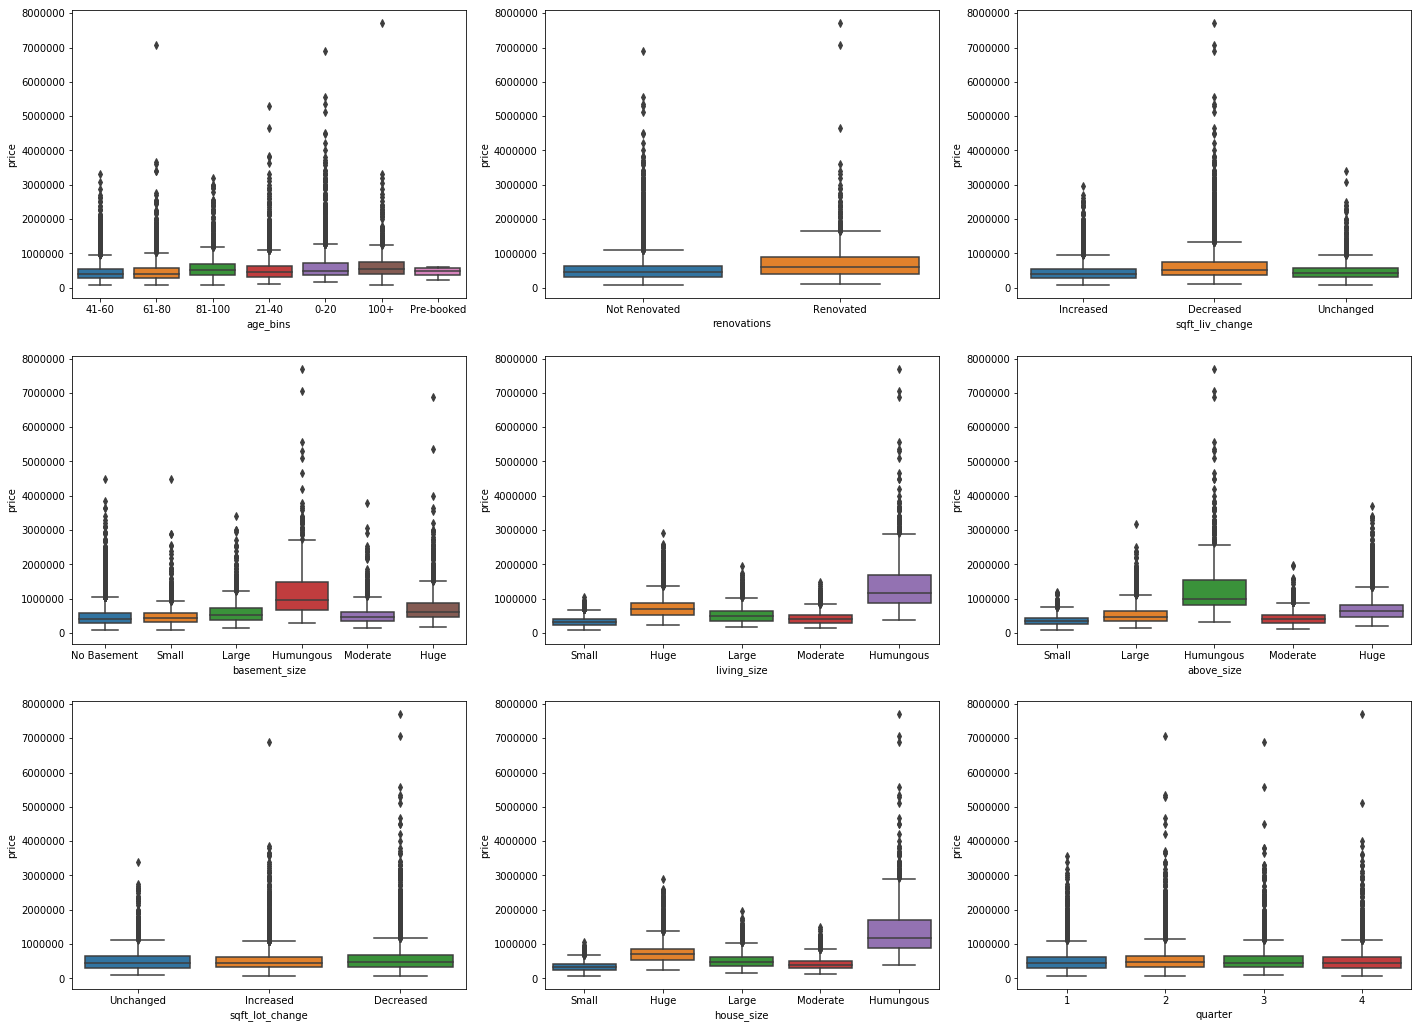

In [306]:
plt.figure(figsize= (24, 18))

for idx, col in enumerate(['age_bins', 'renovations', 'sqft_liv_change', 'basement_size', 'living_size', 'above_size','sqft_lot_change', 'house_size', 'quarter']):
    
    plt.subplot(3, 3, idx+1)
    
    sns.boxplot(x= col, y= 'price', data= df)

In [307]:
num_cols

['sqft_living',
 'sqft_lot',
 'sqft_above',
 'sqft_basement',
 'sqft_living15',
 'sqft_lot15',
 'Total_sqft']

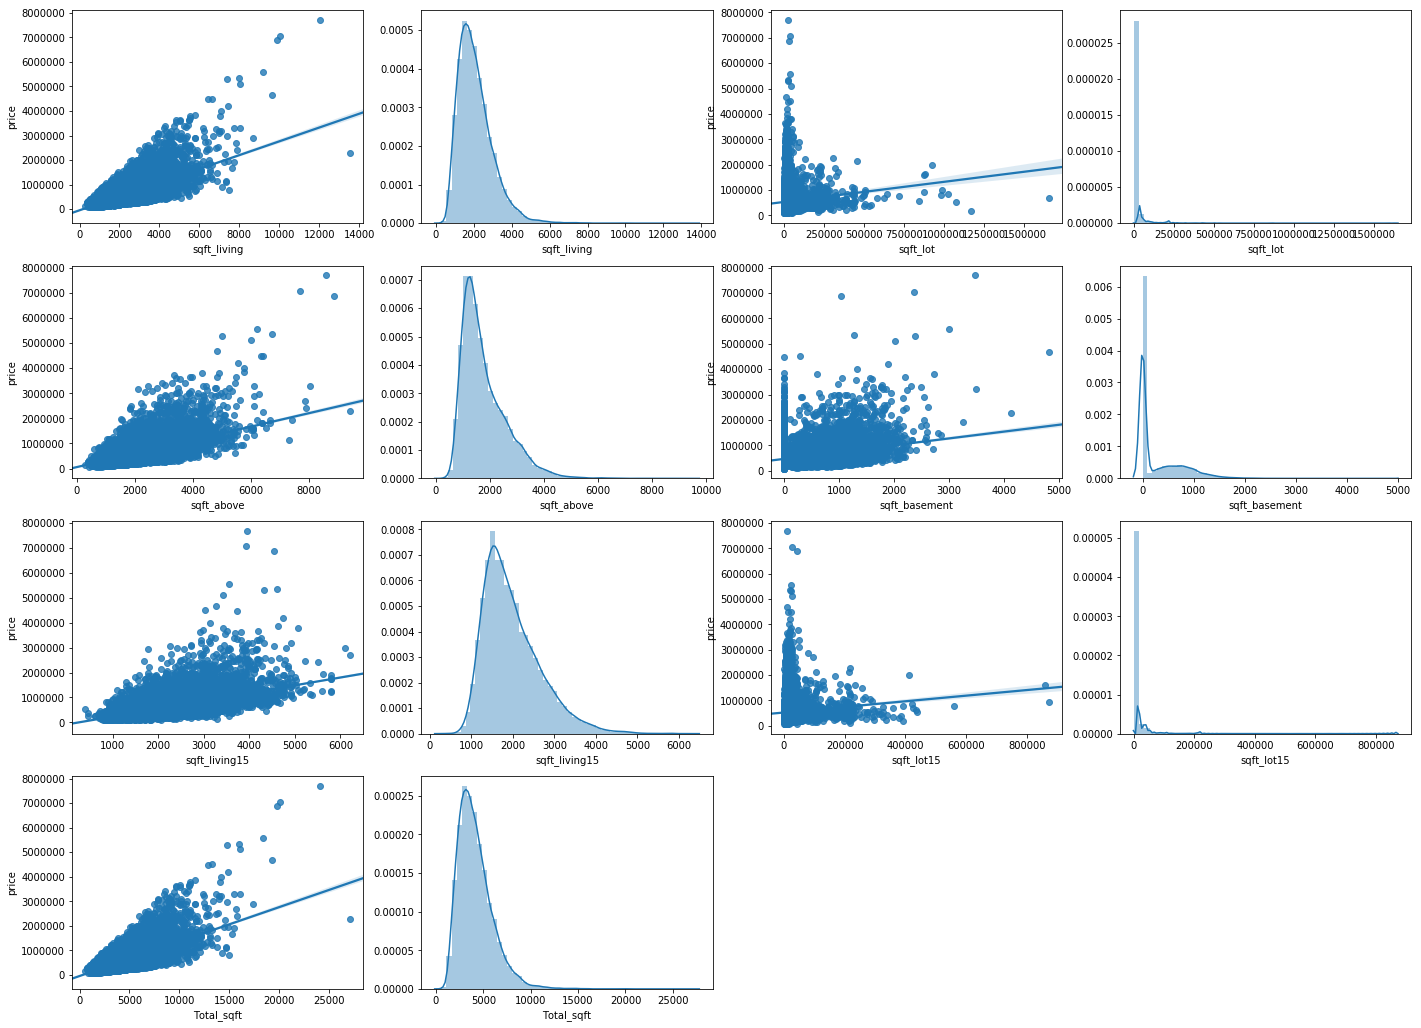

In [308]:
plt.figure(figsize= (24, 18))

count= 1

for idx, col in enumerate(num_cols):
    
    plt.subplot(4, 4, count)
    
    sns.regplot(x= col, y= 'price', data= df)
    plt.xlabel(col)
    
    count+=1
    
    plt.subplot(4, 4, count)
    sns.distplot(df[col])
    count+=1

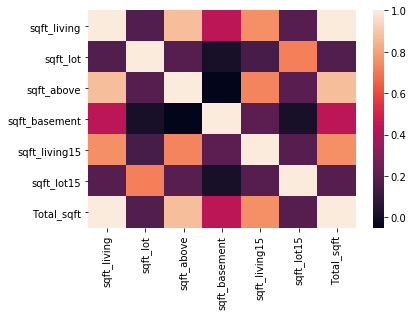

In [309]:
sns.heatmap(df[num_cols].corr())

In [310]:
# we'll drop the numerical columns from the DataFrame for now

df.sample(3)

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,zipcode,sqft_living15,sqft_lot15,Year,Month,quarter,weekday,Total_sqft,age_bins,renovations,sqft_liv_change,basement_size,living_size,above_size,sqft_lot_change,house_size
16161,450500.0,3,1.0,1410,9384,1,0,0,3,7,1410,0,Seattle,1990,9384,2015,3,1,4,2820,61-80,Not Renovated,Increased,No Basement,Small,Moderate,Unchanged,Small
20796,272000.0,3,2.5,1528,7616,2,0,0,3,7,1528,0,Kent,1850,7340,2015,4,2,1,3056,0-20,Not Renovated,Increased,No Basement,Moderate,Moderate,Decreased,Moderate
12413,661254.0,4,4.0,2290,6250,1.5,0,0,5,7,1690,600,Seattle,1920,4335,2014,5,2,4,4580,61-80,Not Renovated,Decreased,Moderate,Large,Large,Decreased,Large


In [311]:
df.drop(num_cols, axis= 1, inplace= True) #dropped

In [312]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'floors', 'waterfront', 'view',
       'condition', 'grade', 'zipcode', 'Year', 'Month', 'quarter', 'weekday',
       'age_bins', 'renovations', 'sqft_liv_change', 'basement_size',
       'living_size', 'above_size', 'sqft_lot_change', 'house_size'],
      dtype='object')

In [313]:
obj= ['bedrooms', 'bathrooms', 'floors', 'waterfront', 'view','condition', 'grade', 'zipcode','Year'
      , 'Month', 'quarter','weekday', 'age_bins', 'renovations', 'sqft_liv_change', 'basement_size'
      , 'living_size', 'above_size', 'sqft_lot_change', 'house_size']

In [314]:
df[obj]= df[obj].applymap(str) #creating object from all the other features to make dummies

In [315]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
price              21613 non-null float64
bedrooms           21613 non-null object
bathrooms          21613 non-null object
floors             21613 non-null object
waterfront         21613 non-null object
view               21613 non-null object
condition          21613 non-null object
grade              21613 non-null object
zipcode            21613 non-null object
Year               21613 non-null object
Month              21613 non-null object
quarter            21613 non-null object
weekday            21613 non-null object
age_bins           21613 non-null object
renovations        21613 non-null object
sqft_liv_change    21613 non-null object
basement_size      21613 non-null object
living_size        21613 non-null object
above_size         21613 non-null object
sqft_lot_change    21613 non-null object
house_size         21613 non-null object
dtypes: float64(1), object(20

In [316]:
df_train= pd.get_dummies(df, drop_first=True)

In [317]:
print(df_train.shape)
df_train.head()

(21613, 139)


,price,bedrooms_1,bedrooms_10,bedrooms_11,bedrooms_2,bedrooms_3,bedrooms_33,bedrooms_4,bedrooms_5,bedrooms_6,bedrooms_7,bedrooms_8,bedrooms_9,bathrooms_0.5,bathrooms_0.75,bathrooms_1.0,bathrooms_1.25,bathrooms_1.5,bathrooms_1.75,bathrooms_2.0,bathrooms_2.25,bathrooms_2.5,bathrooms_2.75,bathrooms_3.0,bathrooms_3.25,bathrooms_3.5,bathrooms_3.75,bathrooms_4.0,bathrooms_4.25,bathrooms_4.5,bathrooms_4.75,bathrooms_5.0,bathrooms_5.25,bathrooms_5.5,bathrooms_5.75,bathrooms_6.0,bathrooms_6.25,bathrooms_6.5,bathrooms_6.75,bathrooms_7.5,...,Month_7,Month_8,Month_9,quarter_2,quarter_3,quarter_4,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,age_bins_100+,age_bins_21-40,age_bins_41-60,age_bins_61-80,age_bins_81-100,age_bins_Pre-booked,renovations_Renovated,sqft_liv_change_Increased,sqft_liv_change_Unchanged,basement_size_Humungous,basement_size_Large,basement_size_Moderate,basement_size_No Basement,basement_size_Small,living_size_Humungous,living_size_Large,living_size_Moderate,living_size_Small,above_size_Humungous,above_size_Large,above_size_Moderate,above_size_Small,sqft_lot_change_Increased,sqft_lot_change_Unchanged,house_size_Humungous,house_size_Large,house_size_Moderate,house_size_Small
0,221900.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1
1,538000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0
2,180000.0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1
3,604000.0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,1,0,0
4,510000.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0


In [318]:
# we have 112 columns we'll go with it for now

X, y= df_train.drop('price', axis= 1),df_train['price']

In [319]:
print(y.min(), y.max())

75000.0 7700000.0


In [320]:
y= y.div(1000)
y.min(), y.max()

(75.0, 7700.0)

In [321]:
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size= 0.2, random_state= 123)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((17290, 138), (4323, 138), (17290,), (4323,))

In [322]:
print(y_train.head())
print(y_test.head())

14305    848.00
19844    659.95
2686     343.00
11926    522.50
13873    390.00
Name: price, dtype: float64
5506     532.5
9279     410.0
16034    782.5
6608     995.0
20359    279.0
Name: price, dtype: float64


In [323]:
y_test.reset_index(drop= True, inplace= True)

In [324]:
y_test.head()

0    532.5
1    410.0
2    782.5
3    995.0
4    279.0
Name: price, dtype: float64

In [325]:
lr= LinearRegression()

lr.fit(X_train, y_train)

lr_pred= lr.predict(X_test)

print(mean_squared_error(y_test, lr_pred))
print(r2_score(y_test, lr_pred))

1.1107575727260132e+25
-7.865398061727773e+19


In [326]:
pd.concat([y_test, pd.Series(lr_pred)], axis= 1).sample(10)

,price,0
2,782.50,771.725019
868,825.00,928.746620
2566,565.00,505.415843
1241,374.90,406.917134
2219,300.00,319.040843
3582,1530.00,1301.353343
759,635.00,1045.665843
276,175.00,262.040843
4147,677.79,578.094875
3487,580.00,514.509593


In [327]:
d_tree= DecisionTreeRegressor()

d_tree.fit(X_train, y_train)

d_pred= d_tree.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, d_pred)))
print(r2_score(y_test, d_pred))

# we have better results here than the linear model
# we will no try for Random Forest


223.44328418060425
0.6464620526331355


In [328]:
pd.concat([y_test, pd.Series(d_pred)], axis= 1).head(10)

,price,0
0,532.5,565.00
1,410.0,435.00
2,782.5,1080.00
3,995.0,1010.00
4,279.0,260.00
5,175.0,250.00
6,689.0,566.00
7,275.0,379.95
8,465.0,403.00
9,506.0,345.10


In [329]:
rf_reg= RandomForestRegressor() # we'll just fit of the book RandomForest model

rf_reg.fit(X_train, y_train)

rf_pred= rf_reg.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, rf_pred)))
print(r2_score(y_test, rf_pred))

# we have a slightly better model with the RandomForest model
# let's check gradient boosting and extra trees and SGD regressors and then we will start fine tuning our 
# model

184.35004446177382
0.759348863279521


In [330]:
pd.concat([y_test, pd.Series(rf_pred)], axis= 1).head(8)

,price,0
0,532.5,618.6300
1,410.0,415.2334
2,782.5,808.6307
3,995.0,962.0000
4,279.0,288.1700
5,175.0,254.5500
6,689.0,634.8570
7,275.0,387.1900


In [331]:
gbm_reg = GradientBoostingRegressor() #we'll again use off the book model here then fine tune it later

et_reg= ExtraTreesRegressor()

sgd_reg= SGDRegressor()

In [332]:
gbm_reg.fit(X_train, y_train)

gbm_pred= gbm_reg.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, gbm_pred)))
print(r2_score(y_test, gbm_pred))
# we get better score than RandomForest

174.87401093664963
0.7834531022351254


In [333]:
et_reg.fit(X_train, y_train)

et_pred= et_reg.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, et_pred)))
print(r2_score(y_test, et_pred))

# this didn't perform as well as the others

213.0501680583549
0.6785857064496077


In [334]:
sgd_reg.fit(X_train, y_train)

sgd_pred= sgd_reg.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, sgd_pred)))
print(r2_score(y_test, sgd_pred))

# we get a better model than a simple linear model
# we will see if we can stack this model later

207.04049744624902
0.6964627263960892


In [335]:
# for now we will use Grid search for hyper parameter tuning

gb_params= {'alpha':[.8, .7, .9],
            'max_depth': np.arange(1, 10, 1), 
            'max_features':[.7, .8]
            }

gb_grid= GridSearchCV(gbm_reg, gb_params, scoring= 'r2', cv= 5, n_jobs=-1, verbose= 1)

gb_grid.fit(X_train, y_train)

gb_grid_pred= gb_grid.predict(X_test)

print(np.sqrt(mean_squared_error(y_test, gb_grid_pred)))
print(r2_score(y_test, gb_grid_pred))

# we did get a better score, we will train a model with the best estimator from our grid search and train
# the model again


Fitting 5 folds for each of 54 candidates, totalling 270 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:   58.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 12.3min
[Parallel(n_jobs=-1)]: Done 270 out of 270 | elapsed: 18.6min finished


165.0478814807492
0.8071048392529616


In [336]:
gbm_reg= gb_grid.best_estimator_

In [337]:
gbm_reg.fit(X_train, y_train)

gbm_pred = gbm_reg.predict(X_test)

r2_score(y_test, gbm_pred)

# we see that we have a better score.

0.7978124385821578

In [338]:
gbm_reg.fit(X, y)

gbm_pred1= gbm_reg.predict(X)

r2_score(y, gbm_pred1)

# we see that the model is giving 85% r2score
# we will stop model building here.

0.8586204041387201